In [1]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, grid_size=3, gamma=0.9, penalty=-12, reward=10, goal_reward=5, max_steps=5):
        self.grid_size = grid_size
        self.gamma = gamma
        self.penalty = penalty
        self.reward = reward
        self.goal_reward = goal_reward
        self.max_steps = max_steps
        self.state_visits = np.zeros((grid_size, grid_size))
        self.reset()
        self.start = (0, 0)  # Define the start position

    def reset(self):
        self.x = 0
        self.y = 0
        self.steps = 0
        self.state_visits[:] = 0
        return (self.x, self.y)

    def step(self, action):
        self.state_visits[self.x, self.y] += 1

        if action == 0 and self.y != 0:
            self.y -= 1
        elif action == 1 and self.x != self.grid_size-1:
            self.x += 1
        elif action == 2 and self.y != self.grid_size-1:
            self.y += 1
        elif action == 3 and self.x != 0:
            self.x -= 1

        self.steps += 1

        if self.x == self.grid_size - 1 and self.y == self.grid_size - 1:
            return (self.x, self.y), self.goal_reward, True
        elif self.steps >= self.max_steps:
            return (self.x, self.y), 0, True
        else:
            return (self.x, self.y), np.random.choice([self.penalty, self.reward], p=[0.5, 0.5]), False

    def get_epsilon(self, state):
        x, y = state
        n_s = self.state_visits[x, y]
        return 1 / np.sqrt(n_s + 1)

In [2]:
def Q_learning(env, num_episodes, max_steps):
    Q_table = np.zeros((env.grid_size, env.grid_size, 4))
    N_table = np.zeros((env.grid_size, env.grid_size, 4))  # Keep track of the counts
    rewards = np.zeros(num_episodes)
    max_action_values = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        # alpha = 1 / (episode + 1)  # Decaying learning rate
        while not done and steps < max_steps:
            # epsilon = env.get_epsilon(state)
            epsilon = 1 / np.sqrt(episode + 1)  # Decaying epsilon
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, 4)  # Explore
            else:
                action = np.argmax(Q_table[state])  # Exploit
            next_state, reward, done = env.step(action)
            total_reward += reward
            steps += 1
            N_table[state][action] += 1  # Increase the count
            alpha = 1 / N_table[state][action]  # Decaying learning rate based on the count
            target = reward + env.gamma * np.max(Q_table[next_state])
            Q_table[state][action] = Q_table[state][action] + alpha * (target - Q_table[state][action])
            state = next_state
        rewards[episode] = total_reward
        max_action_values.append(np.max(Q_table[env.start]))
    average_rewards = np.cumsum(rewards) / (np.arange(num_episodes) + 1)
    return average_rewards, max_action_values

def double_Q_learning(env, num_episodes, max_steps):
    Q1_table = np.zeros((env.grid_size, env.grid_size, 4))
    Q2_table = np.zeros((env.grid_size, env.grid_size, 4))
    N_table = np.zeros((env.grid_size, env.grid_size, 4))  # Keep track of the counts
    rewards = np.zeros(num_episodes)
    max_action_values = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        # alpha = 1 / (episode + 1)  # Decaying learning rate
        while not done and steps < max_steps:
            # epsilon = env.get_epsilon(state)
            epsilon = 1 / np.sqrt(episode + 1)  # Decaying epsilon
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, 4)  # Explore
            else:
                action = np.argmax(Q1_table[state] + Q2_table[state])  # Exploit
            next_state, reward, done = env.step(action)
            total_reward += reward
            steps += 1
            N_table[state][action] += 1  # Increase the count
            alpha = 1 / N_table[state][action]  # Decaying learning rate based on the count
            if np.random.uniform(0, 1) < 0.5:
                target = reward + env.gamma * Q2_table[next_state][np.argmax(Q1_table[next_state])]
                Q1_table[state][action] = Q1_table[state][action] + alpha * (target - Q1_table[state][action])
            else:
                target = reward + env.gamma * Q1_table[next_state][np.argmax(Q2_table[next_state])]
                Q2_table[state][action] = Q2_table[state][action] + alpha * (target - Q2_table[state][action])
            state = next_state
        rewards[episode] = total_reward
        max_action_values.append(np.max(Q1_table[env.start] + Q2_table[env.start]))
    average_rewards = np.cumsum(rewards) / (np.arange(num_episodes) + 1)
    return average_rewards, max_action_values


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def smoothed_Q_learning(env, num_episodes, max_steps, smoothing_strategy="softmax"):
    Q_table = np.zeros((env.grid_size, env.grid_size, 4))
    N_table = np.zeros((env.grid_size, env.grid_size, 4))  # Keep track of the counts
    rewards = np.zeros(num_episodes)
    max_action_values = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        # alpha = 1 / (episode + 1)  # Decaying learning rate
        while not done and steps < max_steps:
            # epsilon = env.get_epsilon(state)
            epsilon = 1 / np.sqrt(episode + 1)  # Decaying epsilon
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, 4)  # Explore
            else:
                action = np.argmax(Q_table[state])  # Exploit

            next_state, reward, done = env.step(action)
            total_reward += reward
            steps += 1
            N_table[state][action] += 1  # Increase the count
            alpha = 1 / N_table[state][action]  # Decaying learning rate based on the count
            if smoothing_strategy == "softmax":
                qt = softmax(Q_table[next_state])
            else:
                qt = np.ones(4) / 3
                qt[np.argmax(Q_table[next_state])] = 1 / 3

            target = reward + env.gamma * np.sum(qt * Q_table[next_state])
            Q_table[state][action] = Q_table[state][action] + alpha * (target - Q_table[state][action])

            state = next_state

        rewards[episode] = total_reward
        max_action_values.append(np.max(Q_table[env.start]))

    average_rewards = np.cumsum(rewards) / (np.arange(num_episodes) + 1)

    return average_rewards, max_action_values


In [15]:
"""

Prior Mean (mu_prior)
In Gridworld, the agent receives a mixture of penalties and rewards as it navigates through the grid, with a special goal reward for reaching the terminal state. Since the agent randomly receives either a penalty or a reward with equal probability at non-terminal states and considering the impact of the goal reward, the prior mean should reflect an average outcome of these interactions. Given the penalty of -12, a reward of 10, and a goal reward of 5, but considering that the goal reward is only received once at the end, a slightly pessimistic or neutral prior mean might be appropriate. For instance, considering the mixed nature of outcomes, a mu_prior around -1 or 0 might initially set a neutral expectation, reflecting uncertainty about whether penalties or rewards will dominate the agent's experience.

Prior Variance (sigma_prior)
The variance should capture the uncertainty or variability in the agent's expectations about rewards. Given the stark contrast between penalties and rewards in this environment, a relatively high variance would be appropriate to capture the wide range of possible outcomes the agent can expect. A sigma_prior of around 1 to 5 could be suitable, indicating significant uncertainty in initial reward expectations.

Observation Noise (sigma_observation)
The observation noise reflects the variance or "noise" in the observed rewards, apart from the agent's inherent uncertainty. In this Gridworld setup, where the agent has a 50/50 chance to receive either a penalty or a reward at non-terminal states, the variability in observed rewards can be considered as part of the environment's inherent randomness. Since the rewards and penalties are distinct and deterministic once the outcome of the random choice is known, the observation noise could be relatively low. However, to account for the randomness in selecting between a penalty and a reward, a sigma_observation of around 0.1 to 1 could acknowledge this aspect without overly emphasizing it.

"""

mu_prior = -1
sigma_prior = 3
sigma_observation = 0.5

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def update_bayesian_posterior(mu_prior, sigma_prior, rewards, sigma_observation=0.5):
    n = len(rewards)
    reward_sum = np.sum(rewards)
    sigma_posterior_squared = 1 / (1 / sigma_prior**2 + n / sigma_observation**2)
    mu_posterior = (mu_prior / sigma_prior**2 + reward_sum / sigma_observation**2) * sigma_posterior_squared
    return mu_posterior, np.sqrt(sigma_posterior_squared)

def smoothed_Q_learning_with_Cognitive_model(env, num_episodes, max_steps, mu_prior=-1, sigma_prior=3):
    Q_table = np.zeros((env.grid_size, env.grid_size, 4))
    N_table = np.zeros((env.grid_size, env.grid_size, 4))
    rewards = np.zeros(num_episodes)
    max_action_values = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        episode_rewards = []  # Collect rewards for Bayesian update

        while not done and steps < max_steps:
            epsilon = 1 / np.sqrt(episode + 1)  # Decaying epsilon
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, 4)  # Explore
            else:
                # # Exploit: consider Bayesian update here if applying before action selection
                # action = np.argmax(Q_table[state])  # Exploit
                adjusted_Q_values = Q_table[state] + mu_prior  # assuming mu_prior is the Bayesian-updated expectation
                action = np.argmax(adjusted_Q_values)

            next_state, reward, done = env.step(action)
            episode_rewards.append(reward)
            total_reward += reward
            steps += 1
            N_table[state][action] += 1
            alpha = 1 / N_table[state][action]  # Learning rate based on count

            # Bayesian update
            mu_prior, sigma_prior = update_bayesian_posterior(mu_prior, sigma_prior, episode_rewards, sigma_observation)

            # Use updated mu_prior to adjust Q values
            adjusted_Q = Q_table[next_state] + mu_prior
            qt = softmax(adjusted_Q)  # Apply softmax on adjusted Q values for smoothing

            target = reward + env.gamma * np.dot(qt, adjusted_Q)  # Use dot product for expected return
            Q_table[state][action] = Q_table[state][action] + alpha * (target - Q_table[state][action])

            state = next_state

        rewards[episode] = total_reward
        max_action_values.append(np.max(Q_table[env.start]))

    average_rewards = np.cumsum(rewards) / (np.arange(num_episodes) + 1)

    return average_rewards, max_action_values


In [3]:
num_experiments = 10000
num_episodes = 10000
max_steps = 5

In [4]:
Q_rewards = []
double_Q_rewards = []
Q_max_action_values = []
double_Q_max_action_values = []
smoothed_Q_softmax_rewards = []
smoothed_Q_softmax_max_action_values = []
smoothed_Q_clipped_max_rewards = []
smoothed_Q_clipped_max_max_action_values = []

In [7]:
for _ in range(num_experiments):
    env = GridWorld()
    rewards, max_action_values = Q_learning(env, num_episodes, max_steps)
    Q_rewards.append(rewards)
    Q_max_action_values.append(max_action_values)

print("Q Learning Completed")

Q Learning Completed


In [8]:
for _ in range(num_experiments):
    env = GridWorld()
    rewards, max_action_values = double_Q_learning(env, num_episodes, max_steps)
    double_Q_rewards.append(rewards)
    double_Q_max_action_values.append(max_action_values)

print("Double Q Learning Completed")

Double Q Learning Completed


In [9]:
for _ in range(num_experiments):
    env = GridWorld()
    rewards, max_action_values = smoothed_Q_learning(env, num_episodes, max_steps, smoothing_strategy="softmax")
    smoothed_Q_softmax_rewards.append(rewards)
    smoothed_Q_softmax_max_action_values.append(max_action_values)

print("Smoothed Q Learning Softmax Completed")

Smoothed Q Learning Softmax Completed


In [10]:
for _ in range(num_experiments):
    env = GridWorld()
    rewards, max_action_values = smoothed_Q_learning(env, num_episodes, max_steps, smoothing_strategy="clipped_max")
    smoothed_Q_clipped_max_rewards.append(rewards)
    smoothed_Q_clipped_max_max_action_values.append(max_action_values)

print("Smoothed Q Learning Clipped Max Completed")

Smoothed Q Learning Clipped Max Completed


In [11]:
smoothed_Q_congitive_model_rewards = []
smoothed_Q_congitive_model_max_action_values = []

In [16]:
mu_prior = -1
sigma_prior = 3
for _ in range(num_experiments):
    env = GridWorld()
    rewards, max_action_values = smoothed_Q_learning_with_Cognitive_model(env, num_episodes, max_steps, mu_prior, sigma_prior)
    smoothed_Q_congitive_model_rewards.append(rewards)
    smoothed_Q_congitive_model_max_action_values.append(max_action_values)

print("Smoothed Q Learning Cognition Model Completed")

Smoothed Q Learning Cognition Model Completed


In [17]:
Q_rewards = np.mean(np.array(Q_rewards), axis=0)
double_Q_rewards = np.mean(np.array(double_Q_rewards), axis=0)
Q_max_action_values = np.mean(Q_max_action_values, axis=0)
double_Q_max_action_values = np.mean(double_Q_max_action_values, axis=0)
smoothed_Q_softmax_rewards = np.mean(np.array(smoothed_Q_softmax_rewards), axis=0)
smoothed_Q_softmax_max_action_values = np.mean(smoothed_Q_softmax_max_action_values, axis=0)
smoothed_Q_clipped_max_rewards = np.mean(np.array(smoothed_Q_clipped_max_rewards), axis=0)
smoothed_Q_clipped_max_max_action_values = np.mean(smoothed_Q_clipped_max_max_action_values, axis=0)
smoothed_Q_congitive_model_rewards = np.mean(np.array(smoothed_Q_congitive_model_rewards), axis=0)
smoothed_Q_congitive_model_max_action_values = np.mean(np.array(smoothed_Q_congitive_model_max_action_values), axis=0)

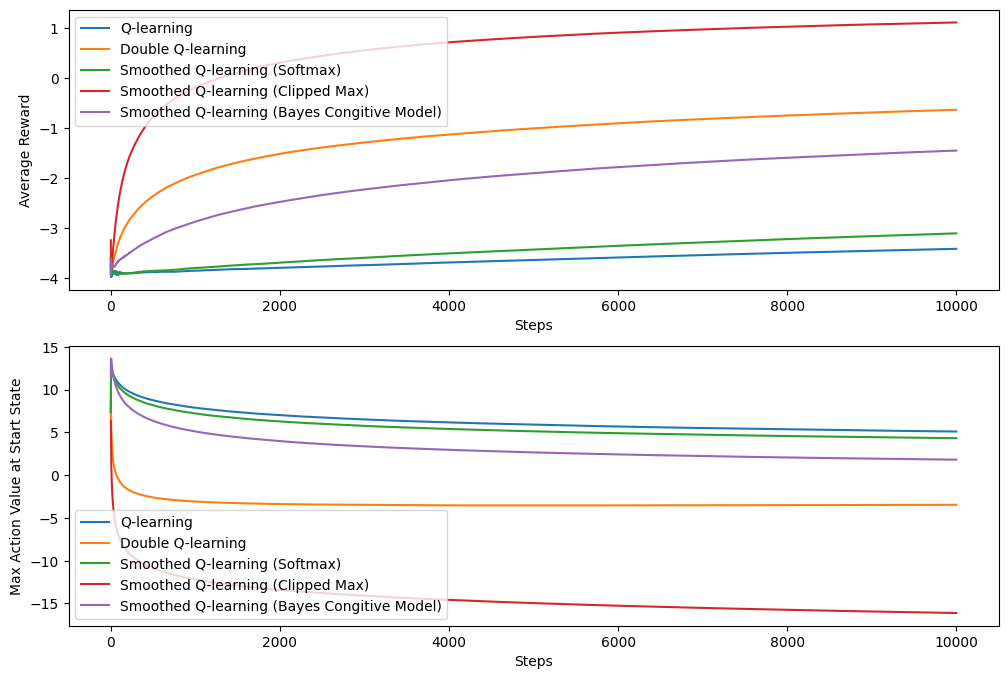

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(Q_rewards, label="Q-learning")
plt.plot(double_Q_rewards, label="Double Q-learning")
plt.plot(smoothed_Q_softmax_rewards, label="Smoothed Q-learning (Softmax)")
plt.plot(smoothed_Q_clipped_max_rewards, label="Smoothed Q-learning (Clipped Max)")
plt.plot(smoothed_Q_congitive_model_rewards, label="Smoothed Q-learning (Bayes Congitive Model)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Q_max_action_values, label="Q-learning")
plt.plot(double_Q_max_action_values, label="Double Q-learning")
plt.plot(smoothed_Q_softmax_max_action_values, label="Smoothed Q-learning (Softmax)")
plt.plot(smoothed_Q_clipped_max_max_action_values, label="Smoothed Q-learning (Clipped Max)")
plt.plot(smoothed_Q_congitive_model_max_action_values, label="Smoothed Q-learning (Bayes Congitive Model)")
plt.xlabel("Steps")
plt.ylabel("Max Action Value at Start State")
plt.legend()

plt.show()